In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import statsmodels.api as sm
from itertools import combinations
# from statsmodels.tsa.stattools import adfuller
import missingno
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


TODO
1. Find cointegration 
2. Find Hedge Ratio
3. Test for ADF to determine stationarity
4. if cointegrate and stationary, then conduct pair trading

In [2]:
tpxUniverse = pd.read_excel('TPX Universe.xlsx')

In [3]:
tpxUniverse.rename(columns={'Avg of Daily Equity Traded Val over 3 Months': 'Avg Daily Val'}, inplace=True)
tpxUniverse.head()

,Ticker,Name,Market Cap,Avg Daily Val,GICS Sector,GICS Ind Grp Name,GICS Ind Name,GICS SubInd Name
0,7203 JP Equity,TOYOTA MOTOR CORP,341.758702,685.901616,Consumer Discretionary,Automobiles & Components,Automobiles,Automobile Manufacturers
1,8306 JP Equity,MITSUBISHI UFJ FINANCIAL GRO,130.140593,699.236250,Financials,Banks,Banks,Diversified Banks
2,6861 JP Equity,KEYENCE CORP,109.377738,250.106395,Information Technology,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components",Electronic Equipment & Instruments
3,6758 JP Equity,SONY GROUP CORP,102.434241,302.709349,Consumer Discretionary,Consumer Durables & Apparel,Household Durables,Consumer Electronics
4,8035 JP Equity,TOKYO ELECTRON LTD,100.907738,964.372108,Information Technology,Semiconductors & Semiconductor Equipment,Semiconductors & Semiconductor Equipment,Semiconductor Materials & Equipment


In [4]:
tpxUniverse.shape

(2139, 8)

In [5]:
# removed ticker list
removedTicker = tpxUniverse[tpxUniverse['Avg Daily Val'] <= 5]['Ticker'].tolist()

In [6]:
#less than 5 Avg Daily Val
tpxUniverse = tpxUniverse[tpxUniverse['Avg Daily Val'] > 5]

In [7]:
tpxUniverse.shape

(555, 8)

In [8]:
tpxData = pd.read_csv('TPX_prices.csv')
tpxData.head()

,Date,7203 JP Equity,8306 JP Equity,6861 JP Equity,6758 JP Equity,8035 JP Equity,6501 JP Equity,9432 JP Equity,8058 JP Equity,8316 JP Equity,...,7508 JP Equity,1870 JP Equity,7085 JP Equity,9997 JP Equity,6101 JP Equity,7239 JP Equity,9755 JP Equity,2752 JP Equity,2157 JP Equity,2681 JP Equity
0,1/1/2013,801.0,461.0,5967.5,958.0,1311.7,2520.0,36.3,549.0,3115.0,...,111.0,435,NaN,304.5,563,1471,1047,269.0,109.4,900
1,2/1/2013,801.0,461.0,5967.5,958.0,1311.7,2520.0,36.3,549.0,3115.0,...,111.0,435,NaN,304.5,563,1471,1047,269.0,109.4,900
2,3/1/2013,801.0,461.0,5967.5,958.0,1311.7,2520.0,36.3,549.0,3115.0,...,111.0,435,NaN,304.5,563,1471,1047,269.0,109.4,900
3,4/1/2013,852.0,484.0,6265.0,968.0,1345.0,2650.0,36.9,570.0,3225.0,...,111.8,436,NaN,311.0,585,1535,1049,264.3,110.6,908
4,7/1/2013,837.0,476.0,6022.5,957.0,1331.7,2630.0,37.1,563.7,3190.0,...,114.0,439,NaN,311.0,582,1526,1045,263.6,110.8,922


In [9]:
#remove column by list ignore if not in list
tpxData = tpxData.drop(removedTicker,axis=1,errors='ignore')

In [10]:
tpxData.shape

(2979, 542)

In [11]:
pd.set_option('display.precision', 3)
tpxData.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
7203 JP Equity,2979.0,1601.345,520.047,801.0,1264.00,1418.2,1825.50,3872.0
8306 JP Equity,2979.0,701.421,228.041,383.5,567.00,653.1,751.50,1658.0
6861 JP Equity,2979.0,34224.453,19892.139,5967.5,16106.25,31560.0,52450.00,75980.0
6758 JP Equity,2979.0,6557.445,4053.358,936.0,3151.00,5378.0,10905.00,15520.0
8035 JP Equity,2979.0,8886.947,7949.147,1268.3,2605.15,6050.0,14766.70,39620.0
6501 JP Equity,2979.0,4798.576,2372.434,2015.5,3384.50,3960.0,5918.50,16145.0
9432 JP Equity,2979.0,105.138,35.067,36.3,89.85,100.3,116.50,191.2
8058 JP Equity,2979.0,1075.137,575.984,522.3,725.50,896.7,1103.85,3634.0
8316 JP Equity,2979.0,4458.248,1173.443,2550.0,3841.00,4200.5,4700.00,10290.0
9984 JP Equity,2979.0,4850.139,1680.122,1468.0,3678.00,4524.0,5721.25,10635.0


In [12]:
tpxData = tpxData.dropna(axis=1)

In [13]:
tpxData = tpxData.set_index('Date')

In [14]:
#Calculate returns and create a data frame
returns = tpxData.pct_change().mean()*266
returns = pd.DataFrame(returns)
returns.columns = ['returns']

#Calculate the volatility
returns['volatility'] = tpxData.pct_change().std()*np.sqrt(266)

data = returns
data.head()

,returns,volatility
7203 JP Equity,0.162,0.257
8306 JP Equity,0.157,0.293
6861 JP Equity,0.265,0.299
6758 JP Equity,0.287,0.332
8035 JP Equity,0.356,0.365


In [15]:
#Prepare the scaler
scale = StandardScaler().fit(data)

#Fit the scaler
scaled_data = pd.DataFrame(scale.fit_transform(data),columns = data.columns, index = data.index)
X = scaled_data
X.head()

,returns,volatility
7203 JP Equity,-0.067,-1.062
8306 JP Equity,-0.125,-0.542
6861 JP Equity,1.097,-0.463
6758 JP Equity,1.341,0.015
8035 JP Equity,2.124,0.505


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

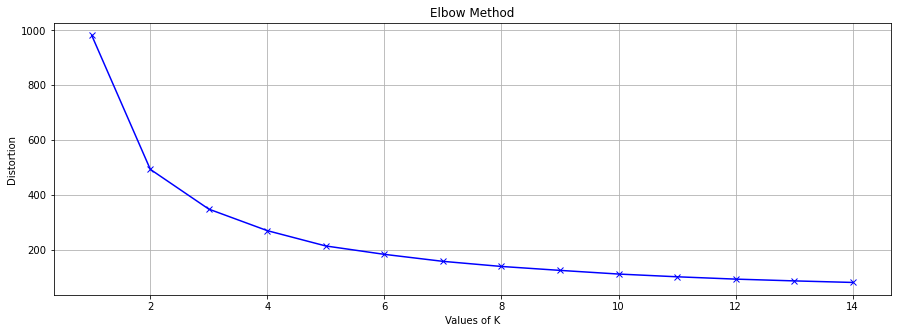

In [16]:
K = range(1,15)
distortions = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

#Plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

In [17]:
from kneed import KneeLocator
kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
kl.elbow

4

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

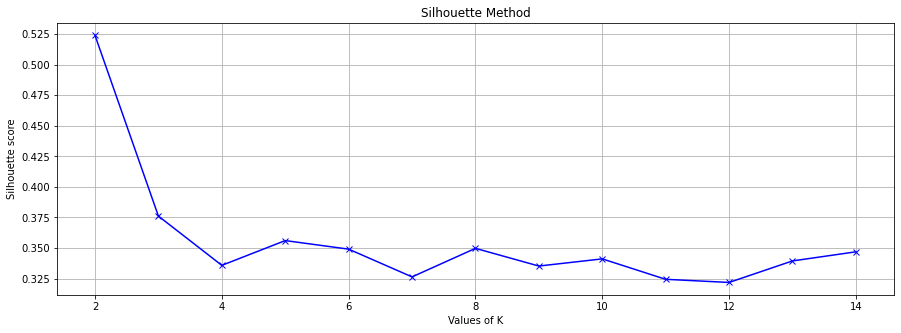

Suggested number of clusters:  4


In [18]:
from sklearn.metrics import silhouette_score

#For the silhouette method k needs to start from 2
K = range(2,15)
silhouettes = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='random')
    kmeans.fit(X)
    silhouettes.append(silhouette_score(X, kmeans.labels_))

#Plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.grid(True)
plt.show()

kl = KneeLocator(K, silhouettes, curve="convex", direction="decreasing")
print('Suggested number of clusters: ', kl.elbow)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


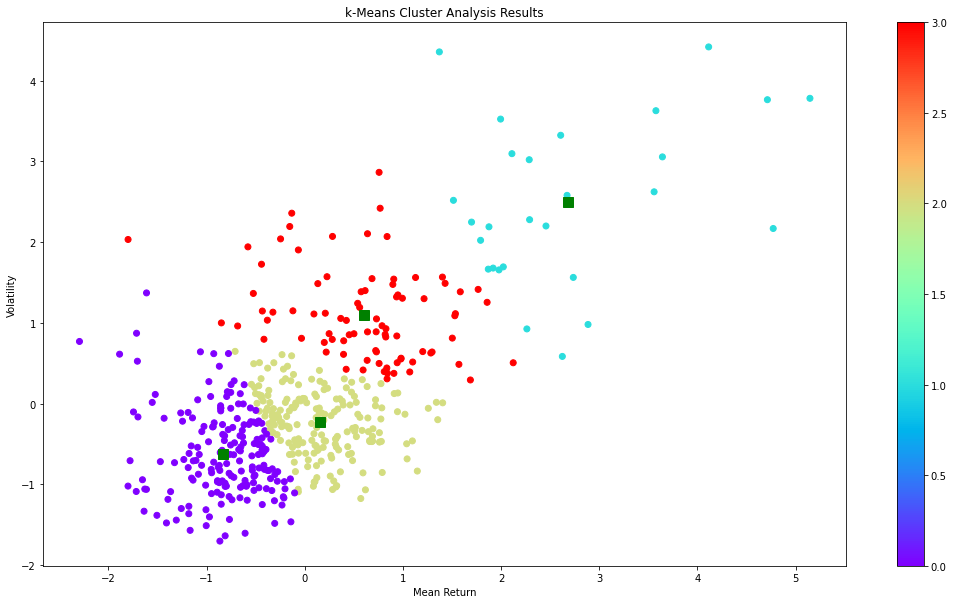

In [19]:
c = 4
#Fit the model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(X)

#Plot the results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label = X.index)
ax.set_title('k-Means Cluster Analysis Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=10)
plt.show()

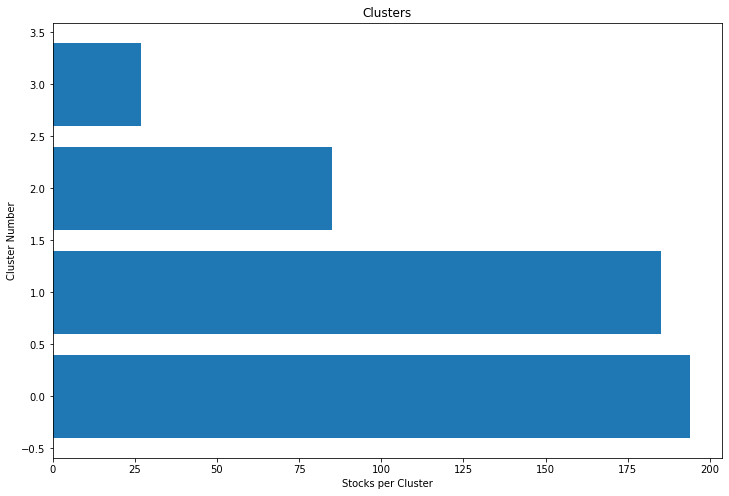

In [20]:
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
plt.figure(figsize=(12,8))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Clusters')
plt.xlabel('Stocks per Cluster')
plt.ylabel('Cluster Number')
plt.show()

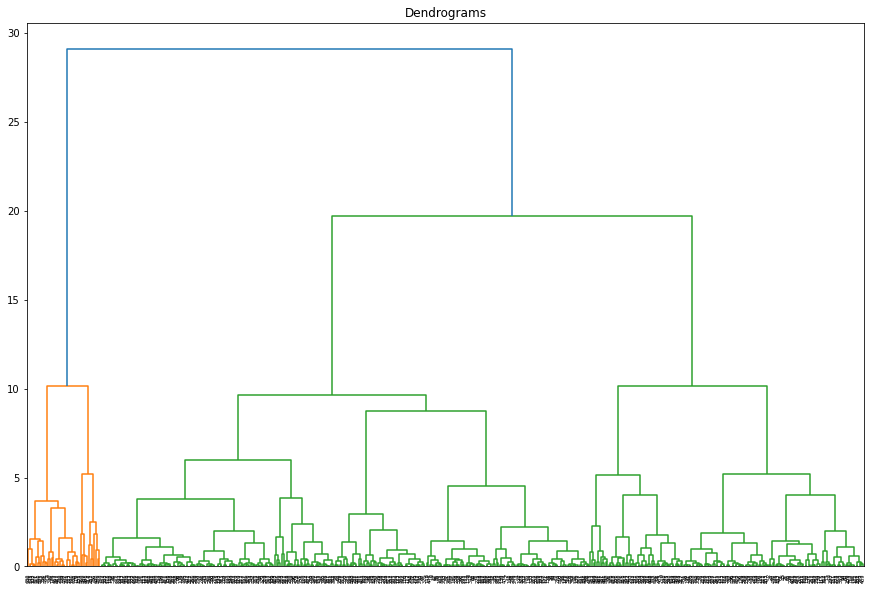

In [21]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(15, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))

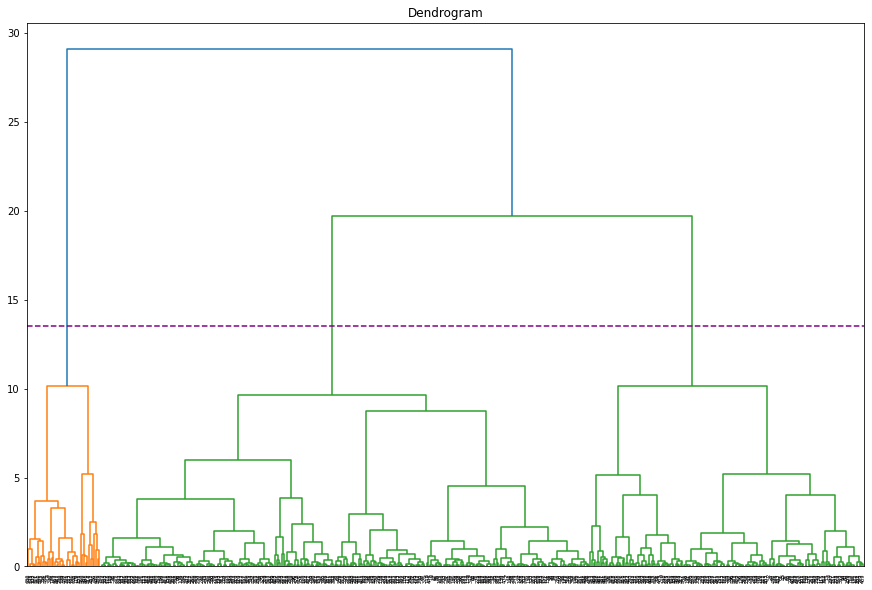

In [22]:
plt.figure(figsize=(15, 10))  
plt.title("Dendrogram")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))
plt.axhline(y=13.5, color='purple', linestyle='--')

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


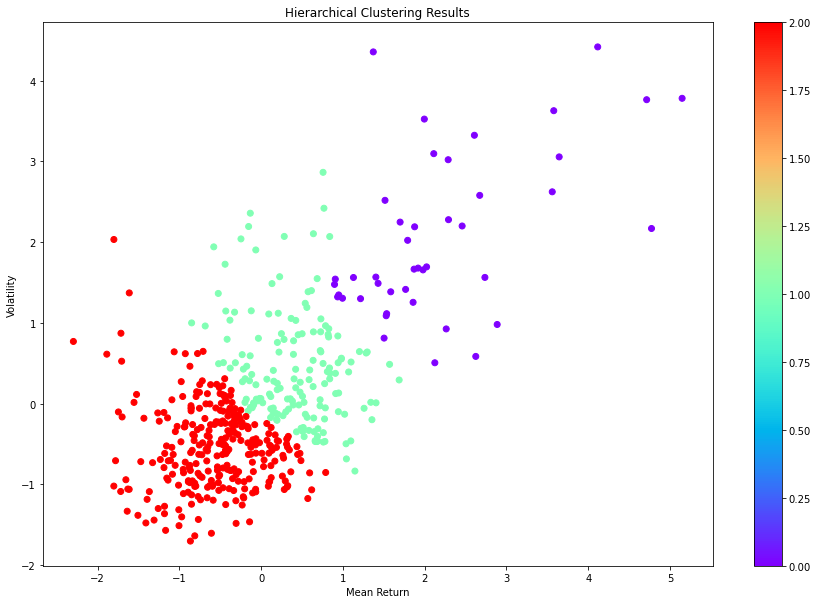

In [23]:
#Fit the model
clusters = 3
hc = AgglomerativeClustering(n_clusters= clusters, affinity='euclidean', linkage='ward')
labels = hc.fit_predict(X)

#Plot the results
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels, cmap='rainbow')
ax.set_title('Hierarchical Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

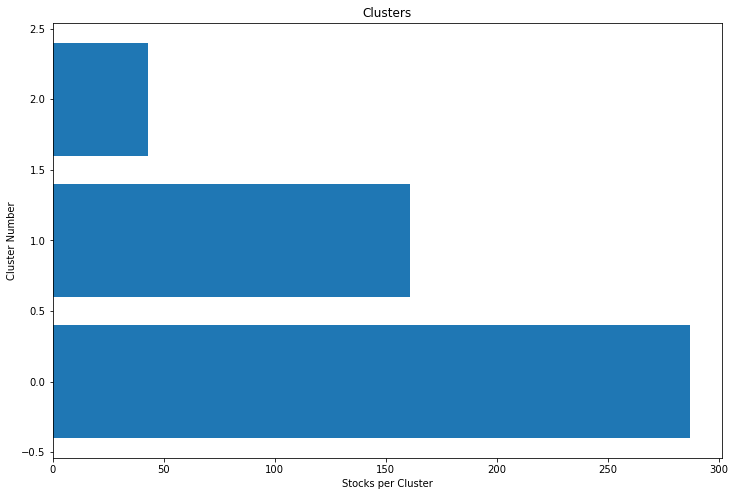

In [24]:
clustered_series = pd.Series(index=X.index, data=hc.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=hc.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
plt.figure(figsize=(12,8))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Clusters')
plt.xlabel('Stocks per Cluster')
plt.ylabel('Cluster Number')
plt.show()

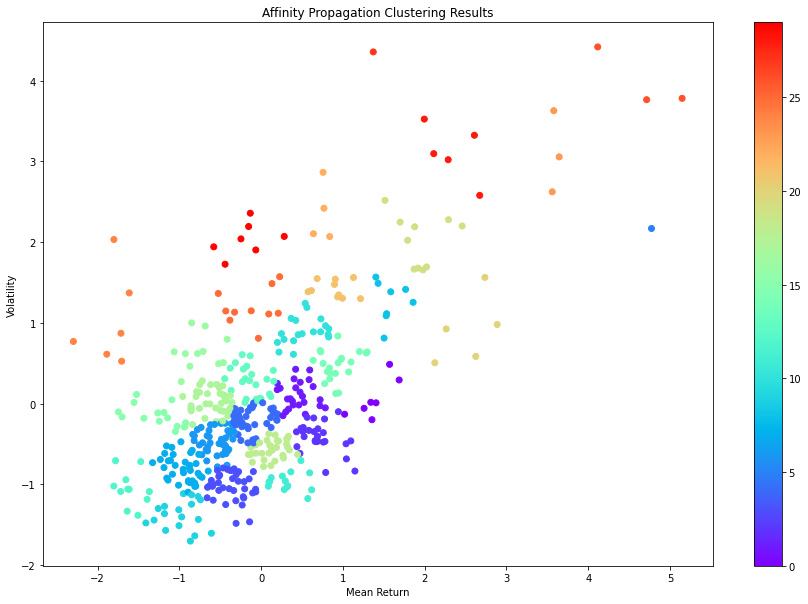

In [25]:
from sklearn.cluster import AffinityPropagation

#Fit the model
ap = AffinityPropagation()
ap.fit(X)
labels1 = ap.predict(X)

#Plot the results
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels1, cmap='rainbow')
ax.set_title('Affinity Propagation Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

The number of clusters is: 30


<Figure size 432x288 with 0 Axes>

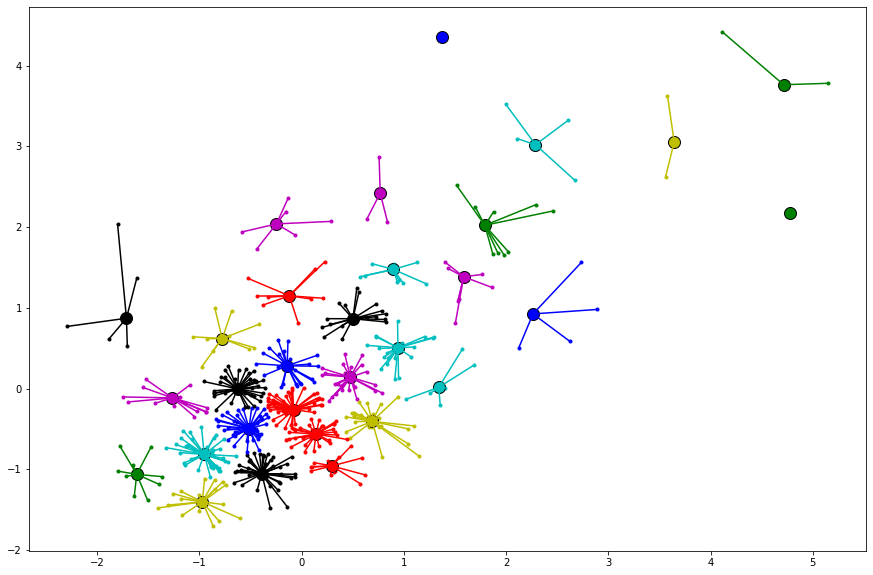

In [26]:
from itertools import cycle

#Extract the cluster centers and labels
cci = ap.cluster_centers_indices_
labels2 = ap.labels_

#Print their number
clusters = len(cci)
print('The number of clusters is:',clusters)

#Plot the results
X_ap = np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf
fig=plt.figure(figsize=(15,10))
colors = cycle('cmykrgbcmykrgbcmykrgbcmykrgb')
for k, col in zip(range(clusters),colors):
    cluster_members = labels2 == k
    cluster_center = X_ap[cci[k]]
    plt.plot(X_ap[cluster_members, 0], X_ap[cluster_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=12)
    for x in X_ap[cluster_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.show()

In [27]:
print("k-Means Clustering", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("Hierarchical Clustering", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("Affinity Propagation Clustering", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

k-Means Clustering 0.3357695288953396
Hierarchical Clustering 0.3662994310000034
Affinity Propagation Clustering 0.3404892077675989


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [28]:
cluster_size_limit = 1000
counts = clustered_series.value_counts()
print(clustered_series.value_counts())
ticker_count = counts[(counts>1) & (counts<=cluster_size_limit)]
print ("Number of clusters: %d" % len(ticker_count))
print ("Number of Pairs: %d" % (ticker_count*(ticker_count-1)).sum())

2    287
1    161
0     43
Name: count, dtype: int64
Number of clusters: 3
Number of Pairs: 109648


In [29]:
def find_cointegrated_pairs(data, significance=0.05):
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [30]:
setattr(pd, "Int64Index", pd.Index)
setattr(pd, "Float64Index", pd.Index)

In [31]:
from statsmodels.tsa.stattools import coint

cluster_dict = {}

for i, clust in enumerate(ticker_count.index):
    tickers = clustered_series[clustered_series == clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(tpxData[tickers])
    cluster_dict[clust] = {}
    cluster_dict[clust]['score_matrix'] = score_matrix
    cluster_dict[clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[clust]['pairs'] = pairs
    
pairs = []   
for cluster in cluster_dict.keys():
    pairs.extend(cluster_dict[cluster]['pairs'])
    
print ("Number of pairs:", len(pairs))
print ("In those pairs, we found %d unique tickers." % len(np.unique(pairs)))
print(pairs)

Number of pairs: 17
In those pairs, we found 20 unique tickers.
[('7203 JP Equity', '8031 JP Equity'), ('7203 JP Equity', '8001 JP Equity'), ('7203 JP Equity', '8002 JP Equity'), ('7203 JP Equity', '8591 JP Equity'), ('7203 JP Equity', '7912 JP Equity'), ('7203 JP Equity', '3231 JP Equity'), ('6861 JP Equity', '6758 JP Equity'), ('6861 JP Equity', '7974 JP Equity'), ('6861 JP Equity', '6367 JP Equity'), ('6861 JP Equity', '7741 JP Equity'), ('6861 JP Equity', '6273 JP Equity'), ('6861 JP Equity', '6702 JP Equity'), ('6861 JP Equity', '2801 JP Equity'), ('8035 JP Equity', '6920 JP Equity'), ('8035 JP Equity', '6323 JP Equity'), ('8035 JP Equity', '5344 JP Equity'), ('8035 JP Equity', '6787 JP Equity')]


In [32]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm

stocks = np.unique(pairs)
X_data = pd.DataFrame(index=X.index, data=X).T
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_data.T.loc[stocks]
X_pairs.head()

,returns,volatility
2801 JP Equity,0.649,-0.349
3231 JP Equity,-0.437,-0.245
5344 JP Equity,1.529,1.088
6273 JP Equity,0.336,-0.069
6323 JP Equity,5.147,3.781


In [33]:
X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(X_pairs)
X_tsne

array([[  8.095001  ,  -8.75704   ],
       [ 51.432518  ,  11.790165  ],
       [-51.166977  , -17.785639  ],
       [ 28.116394  ,  -3.6412458 ],
       [-84.282394  , -11.276071  ],
       [  7.976603  , -19.389559  ],
       [ 20.35249   , -11.977306  ],
       [-27.738613  , -17.828857  ],
       [-65.88618   , -17.02983   ],
       [-11.279105  , -14.14651   ],
       [-79.02383   ,  -3.275668  ],
       [ 84.34354   ,  -0.11885414],
       [ -6.7861433 , -23.554567  ],
       [ 76.846375  ,   7.5602756 ],
       [-38.54266   , -21.991241  ],
       [ 86.38975   , -21.733442  ],
       [ 70.23849   ,  -6.3181963 ],
       [ 79.852234  , -13.334631  ],
       [-46.696087  ,  -6.4589486 ],
       [ 45.441856  ,   3.380551  ]], dtype=float32)

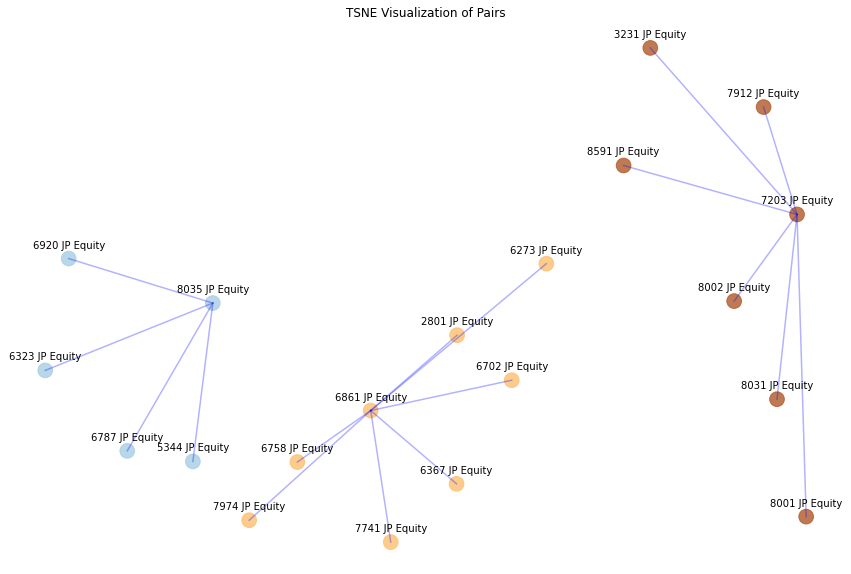

In [34]:
plt.figure(1, facecolor='white',figsize=(15,10))
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    ticker2 = pair[0]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='b');
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('TSNE Visualization of Pairs'); 

# Join pairs by x and y
for x,y,name in zip(X_tsne[:,0],X_tsne[:,1],X_pairs.index):

    label = name

    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')
    
plt.show()

**JL comments: add TPX Universe CSV -- using TPX CSV add new header lines to TPXdata dataframe -- add market cap, daily traded value, GICs ind group name, and GICs Ind name

** JL comments: remove tickers where ADV is less than 5mn

**JL comments: separate the tickers into industry clusters, but clustering them by industry group name -- there should be 24 groups

** JL comments: create an index for each of the 24 groups based on the stocks in the groups 

** JL comments: identify spreads of the stock price moves relative to the index  

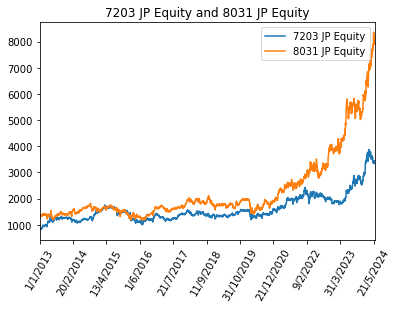

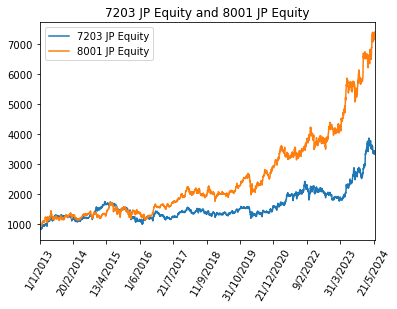

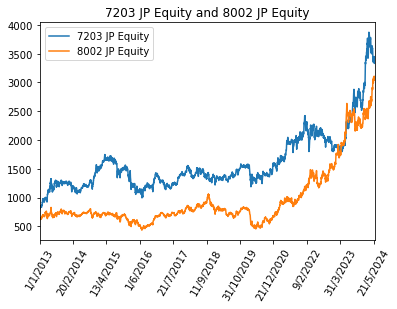

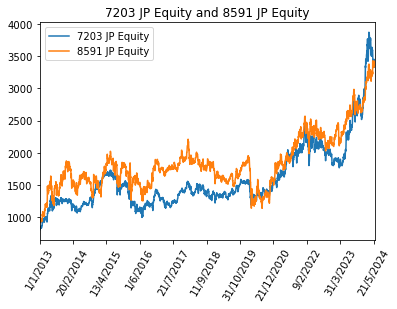

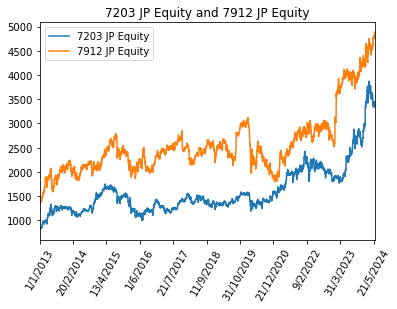

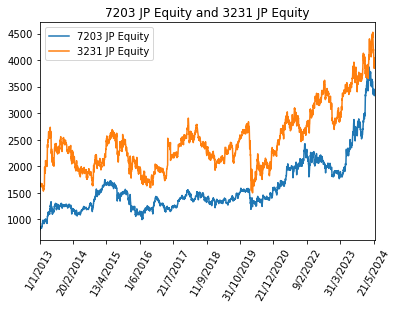

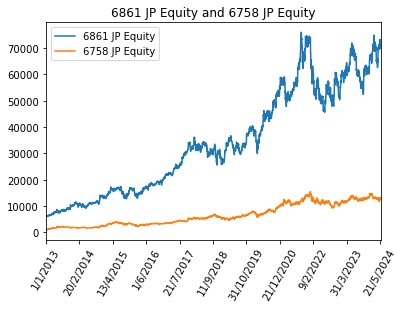

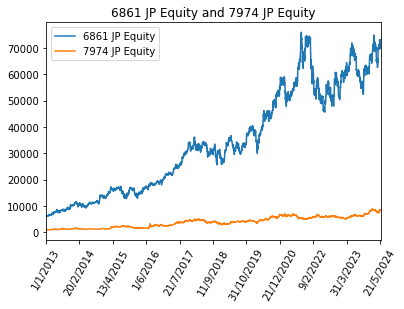

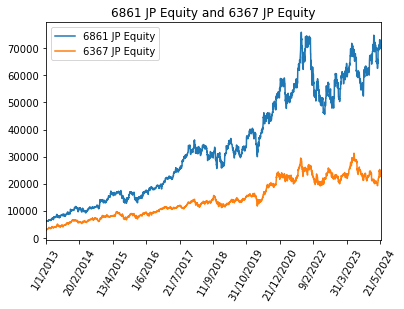

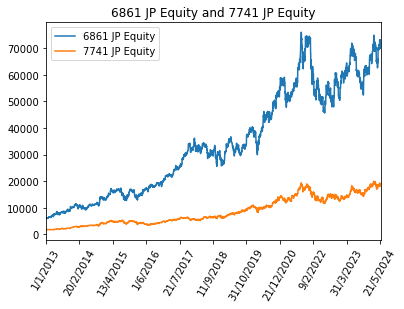

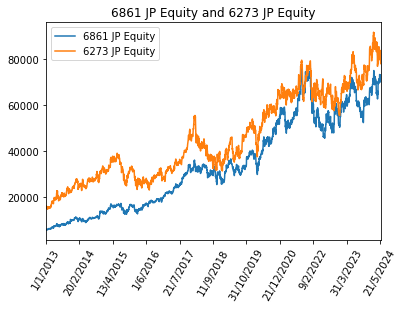

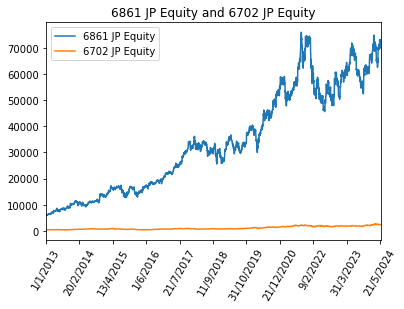

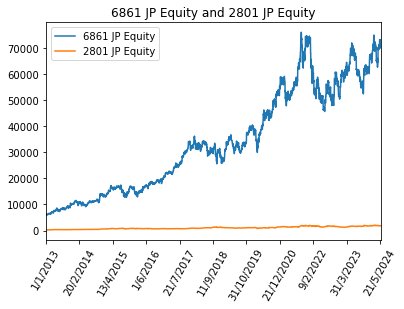

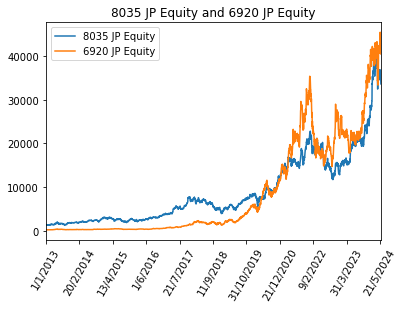

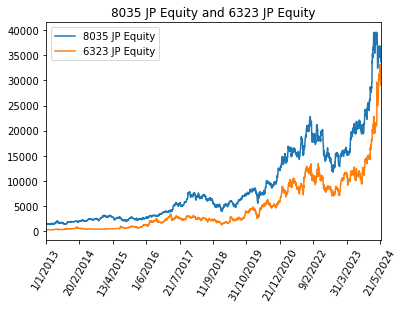

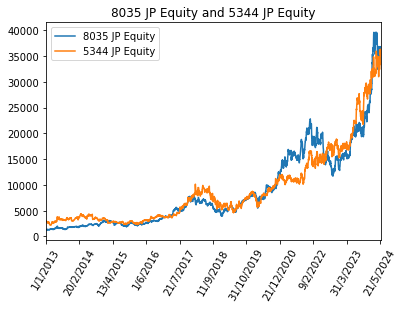

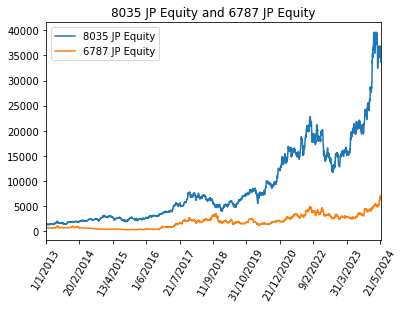

In [74]:
for i in pairs:
    stock1 = i[0]
    stock2 = i[1]
    plt.plot(tpxData[stock1],label = stock1) 
    plt.plot(tpxData[stock2],label = stock2)
    ax = plt.gca()
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::len(xticks) // 10]) # set new tick positions
    ax.tick_params(axis='x', rotation=60) # set tick rotation
    ax.margins(x=0)
    plt.title(stock1 +" and " + stock2)
    plt.legend(loc='best')
    plt.show()
    print()

In [37]:
def findHedgeRatio(x, y):
    """
    Calculates the hedge ratio between two variables.

    Parameters:
    x: panda dataframe timeseries for instrument A
    y: panda dataframe timeseries for instrument B

    Returns:
    float: The hedge ratio.

    """
    model = sm.OLS(x, y).fit()
    return model.params[0]

In [38]:
def findSpread(x, y):
    """
    Calculates the spread between two variables.

    Parameters:
    x: panda dataframe timeseries for instrument A
    y: panda dataframe timeseries for instrument B

    Returns:
    panda dataframe: The spread between the two instruments.

    """
    hedgeRatio = findHedgeRatio(x, y)
    spread = x - hedgeRatio * y
    return spread

In [39]:
def ADFtest(spread):
    """
    Augmented Dickey-Fuller test for stationarity.

    Parameters:
    spread: panda dataframe timeseries

    Returns:
    tuple: ADF test results.
    """
    result = adfuller(spread, maxlag=1)
    return result

In [40]:
def portfolioDiagnostics(signal_df, label):
    #NET SECTOR EXPOSURES
    plt.figure()
    sector_df = pd.read_csv("sector.csv", on_bad_lines='skip') #To be replaced
    d = sector_df.set_index('ticker').to_dict()
    signal_df2 = signal_df.copy(deep=True)
    signal_df2.columns = signal_df2.columns.to_series().map(d['sector']) #To be replaced
    uniquesector = list(set(signal_df2.columns))
    for tsector in uniquesector:
        if (str(tsector)=='nan'):
            continue
        tmean = signal_df2.loc[:, tsector].sum(axis=1)
        tmean[~np.isfinite(tmean)] = 0
        plt.plot(tmean.values, label=tsector)
        plt.legend()
        plt.title(label+" NET EXPOSURE")
    plt.show(block=False)
    return

In [41]:
def pnlPerformance(pnl, label):
    cumpnl = pnl.cumsum(skipna = True)
    sharpe = pnl.mean()/np.std(pnl)
    sharpe = sharpe*np.sqrt(252)
    print("")
    print ("PERFORMANCE STATISTICS FOR "+label)
    print("Daily annualized sharpe: "+str(sharpe))
    print ("Average annual returns: "+str(pnl.mean()*252*100)+"%")
    print ("Total returns: "+str(pnl.sum()*100)+"%")
    highwatermark_df = cumpnl.cummax()
    drawdown_df = cumpnl - highwatermark_df
    maxdrawdown = drawdown_df.min()
    print ("Max drawdown: "+str(maxdrawdown*100)+"%")
    plt.plot(cumpnl.values, label = label)
    plt.legend()
    plt.title("Cumulative PNL chart")
    # TO BE REPLACED 
    # HERE, we compute performance during 'stressed' historical periods
    stressedmarkets = dict()
    stressedmarkets["Covid19"] = (20200301, 20200317)          #Market crash 1H March 2020
    stressedmarkets["Dec18"] = (20181215, 20181231)            #Market crash last 2 weeks
    stressedmarkets["Fall2015"] = (20150701, 20150901)         #Taper tantrum / EU debt crisis.  24 Aug 2015 was "BlackMonday" for Asian, EU and US markets
    stressedmarkets["Oct14"] = (20141001, 20141031)            #Treasury flash crash on 15 Oct 2014
    stressedmarkets["Aug2013"] = (20130820, 20130825)          #Flash freeze on 22 Aug 2013

    for tkey in stressedmarkets.keys():
        mask = pnl.index.to_series().between(stressedmarkets[tkey][0], stressedmarkets[tkey][1])
        print("Stressed period return during "+tkey+":  "+str(pnl[mask].sum()*100)+"%")
    print("===========================")
    print("")